### Projet Machine Learning Python (Valentin Sibertin-Blanc et Bastien Tarnec)

Nous proposons d'étudier et d'établir un algorithme de machine learning pour prédire le cours de l'action Tesla, en appliquant les concepts et algorithmes vus en cours.

In [2]:
import pandas
import numpy
from matplotlib.pyplot import plot
from matplotlib.pyplot import show
from matplotlib.pyplot import figure
from matplotlib.pyplot import title
from matplotlib.pyplot import xlabel
from matplotlib.pyplot import ylabel
from matplotlib.pyplot import legend

Tout d'abord nous importons les données que nous allons utiliser.

In [4]:
data = pandas.read_csv('TSLA.csv', delimiter=',', decimal='.', parse_dates=['Date'])
data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1572 non-null   datetime64[ns]
 1   Open       1572 non-null   float64       
 2   High       1572 non-null   float64       
 3   Low        1572 non-null   float64       
 4   Close      1572 non-null   float64       
 5   Adj Close  1572 non-null   float64       
 6   Volume     1572 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 86.1 KB


Puis les fonctions des différentes librairies dont nous avons avoir besoin.

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Faisons un petit aperçu de la courbe pour commencer.

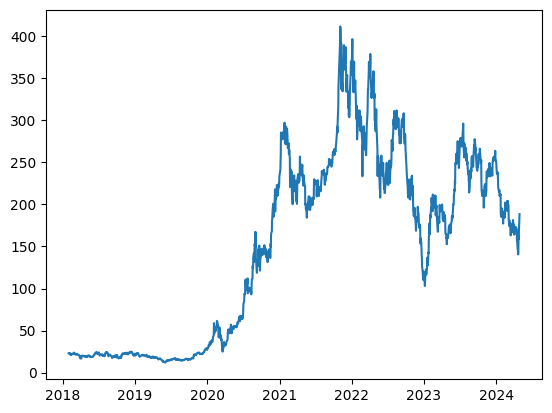

In [6]:
openData = data['Open']
dateData = data['Date']

plot(dateData, openData)
show()

Pour notre projet nous allons utiliser l'algorithme random forest, en temps normal on utilise un échantillon qu'on split de manière à le "mélanger", mais ici nous travaillons sur une série temporelle donc on ne peut pas mélanger les données, au contraire on considère qu'un échantillon donnée ( sur un temps donné donc) influe sur la valeur que l'on cherche à prédire. Il faut donc faire un décalage par rapport à ces données, décalage égal au temps dont on considère qu'il influe sur la valeur à prédire.
Nous commençons par considérer le décalage de 6 mois (ambitieux !) soit environ 180 jours.

In [7]:
for i in range(180, 360):
    data[f'PreviousClose{i}'] = data['Close'].shift(i)
    data[f'PreviousOpen{i}'] = data['Open'].shift(i)
    data[f'PreviousHigh{i}'] = data['High'].shift(i)
    data[f'PreviousLow{i}'] = data['Low'].shift(i)
    data[f'PreviousVolume{i}'] = data['Volume'].shift(i)
    data[f'PreviousAdj Close{i}'] = data['Adj Close'].shift(i)


/tmp/ipykernel_56825/1752680727.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'PreviousOpen{i}'] = data['Open'].shift(i)
/tmp/ipykernel_56825/1752680727.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'PreviousHigh{i}'] = data['High'].shift(i)
/tmp/ipykernel_56825/1752680727.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

On choisit de se concentrer sur la valeur à l'ouverture de chaque jour, donc on retire les autres valeurs puis on parse la date afin d'avoir une valeur temporelle claire.

In [8]:
data.drop(['High', 'Low', 'Close', 'Volume', 'Adj Close'],axis=1,inplace=True)

In [9]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['EndOfYear'] = data['Date'].dt.is_year_end

dateData = data['Date']

/tmp/ipykernel_56825/217800806.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Year'] = data['Date'].dt.year
/tmp/ipykernel_56825/217800806.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Month'] = data['Date'].dt.month
/tmp/ipykernel_56825/217800806.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

In [10]:
# On divise les données en X et y
X = data.drop(columns=['Date', 'Open'])  # On supprime la colonne de date et la cible

y = data['Open']  # On utilise le cours d'ouverture comme notre y

index = int(len(data) * 0.8) # On prend 80% des données pour l'entrainement

dateData = dateData[index:]

In [11]:

# On divise les données en ensembles d'entraînement et de test

X_train = X[:index]
X_test = X[index:]
y_train = y[:index]
y_test = y[index:]

# On entraîne le modèle Random Forest avec bootstrapping
model = RandomForestRegressor(n_estimators=100, random_state=42, bootstrap=True)
model.fit(X_train, y_train)


predictions = model.predict(X_test)

# On calcule l'erreur quadratique moyenne (RMSE)
rmse = numpy.sqrt(mean_squared_error(y_test, predictions))
n_rmse= rmse / y_test.mean()
print(f'RMSE: {rmse}')
print(f'Normalized RMSE: {n_rmse}')


RMSE: 46.50749069337948
Normalized RMSE: 0.2169678406822831


On observe déjà que notre modèle ne semble pas très performant, mais pour l'instant ce n'est pas très parlant, essayons donc d'afficher les courbes pour comparer en commençant par vérifier que les dimensions nous le permettent.

In [12]:
print('Predictions shape :' + str(predictions.shape))
print('y_test shape :' + str(y_test.shape))
print('X_test shape :' + str(X_test.shape))
print('dateData shape :' + str(dateData.shape))

Predictions shape :(315,)
y_test shape :(315,)
X_test shape :(315, 1085)
dateData shape :(315,)


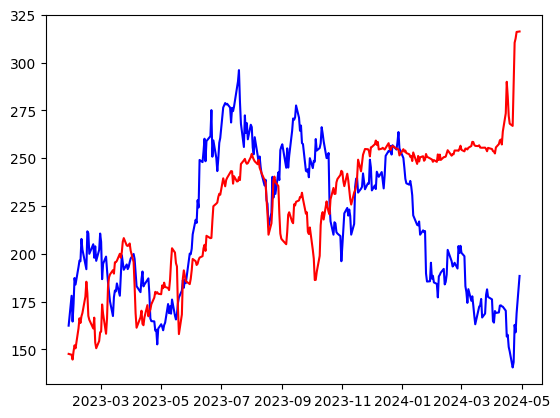

In [13]:
plot(dateData, y_test, 'b-')
plot(dateData, predictions, 'r-')
show()


On constate que c'est un peu un massacre, essayons donc de changer la durée de décalage.

In [14]:
data2 = pandas.read_csv('TSLA.csv', delimiter=',', decimal='.', parse_dates=['Date'])
data2.dropna()
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1572 non-null   datetime64[ns]
 1   Open       1572 non-null   float64       
 2   High       1572 non-null   float64       
 3   Low        1572 non-null   float64       
 4   Close      1572 non-null   float64       
 5   Adj Close  1572 non-null   float64       
 6   Volume     1572 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 86.1 KB


On effectue donc la même chose mais pour 10 jours de décalage.

   PreviousClose10  PreviousOpen10  PreviousHigh10  PreviousLow10  \
0              NaN             NaN             NaN            NaN   
1              NaN             NaN             NaN            NaN   
2              NaN             NaN             NaN            NaN   
3              NaN             NaN             NaN            NaN   
4              NaN             NaN             NaN            NaN   

   PreviousVolume10  PreviousAdj Close10  PreviousClose11  PreviousOpen11  \
0               NaN                  NaN              NaN             NaN   
1               NaN                  NaN              NaN             NaN   
2               NaN                  NaN              NaN             NaN   
3               NaN                  NaN              NaN             NaN   
4               NaN                  NaN              NaN             NaN   

   PreviousHigh11  PreviousLow11  ...  PreviousOpen19  PreviousHigh19  \
0             NaN            NaN  ...            

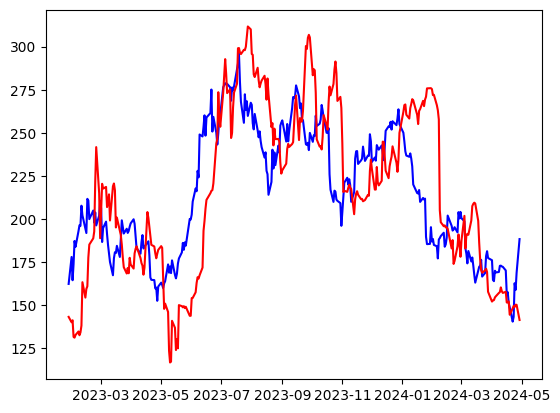

In [15]:
for i in range(10, 20):
    data2[f'PreviousClose{i}'] = data2['Close'].shift(i)
    data2[f'PreviousOpen{i}'] = data2['Open'].shift(i)
    data2[f'PreviousHigh{i}'] = data2['High'].shift(i)
    data2[f'PreviousLow{i}'] = data2['Low'].shift(i)
    data2[f'PreviousVolume{i}'] = data2['Volume'].shift(i)
    data2[f'PreviousAdj Close{i}'] = data2['Adj Close'].shift(i)

data2.drop(['High', 'Low', 'Close', 'Volume', 'Adj Close'],axis=1,inplace=True)

#Add new columns for the year, month, day, day of week, and end of year
data2['Year'] = data2['Date'].dt.year
data2['Month'] = data2['Date'].dt.month
data2['Day'] = data2['Date'].dt.day
data2['DayOfWeek'] = data2['Date'].dt.dayofweek
data2['EndOfYear'] = data2['Date'].dt.is_year_end

dateData2 = data2['Date']

# Diviser les données en fonctionnalités (X) et cible (y)
X = data2.drop(columns=['Date', 'Open'])  # Supprimer la colonne de date et la cible

print(X.head())

y = data2['Open']  # Utiliser le cours d'ouverture comme cible

print(y.head())

index = int(len(data2) * 0.8)

dateData2 = dateData2[index:]



# Diviser les données en ensembles d'entraînement et de test
X_train = X[:index]
X_test = X[index:]
y_train = y[:index]
y_test = y[index:]

# Entraîner un modèle Random Forest avec bootstrapping
model = RandomForestRegressor(n_estimators=100, random_state=42, bootstrap=True)
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
predictions = model.predict(X_test)

# Calculer l'erreur quadratique moyenne (RMSE)
rmse = numpy.sqrt(mean_squared_error(y_test, predictions))
n_rmse= rmse / y_test.mean()
print(f'RMSE: {rmse}')
print(f'Normalized RMSE: {n_rmse}')

print('Predictions shape :' + str(predictions.shape))
print('y_test shape :' + str(y_test.shape))
print('X_test shape :' + str(X_test.shape))
print('dateData2 shape :' + str(dateData2.shape))

plot(dateData2, y_test, 'b-')
plot(dateData2, predictions, 'r-')
show()


Le résultat obtenu est déjà bien meilleur avec une période adapté !

Maintenant nous allons essayer d'utiliser searchCV pour trouver les meilleurs paramètres pour notre modèle.

In [3]:
from sklearn.model_selection import GridSearchCV # Pour la recherche des hyperparamètres optimaux

In [17]:
n_fold = 10

params = {
    'n_estimators': [250, 500, 750, 1000]
}

rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator=rf, param_grid=params, scoring='neg_mean_squared_error', cv=n_fold, n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

# Une fois que le GridSearchCV a fini d'entraîner les modèles et d'évaluer les performances,
# vous pouvez récupérer les meilleurs paramètres et le meilleur modèle entraîné comme ceci :

best_params = rf_grid.best_params_
best_model = rf_grid.best_estimator_

# Vous pouvez alors utiliser le meilleur modèle pour faire des prédictions sur vos données de test :
y_pred = best_model.predict(X_test)

# Et éventuellement évaluer les performances du modèle :
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [18]:
print('rmse : ' + str(numpy.sqrt(mse)))
print('n_rmse : ' + str(numpy.sqrt(mse) / y_test.mean()))

rmse : 34.87850984721174
n_rmse : 0.16271604541421847


In [19]:
print('best paramters for the model are: ', best_params)

best paramters for the model are:  {'n_estimators': 500}


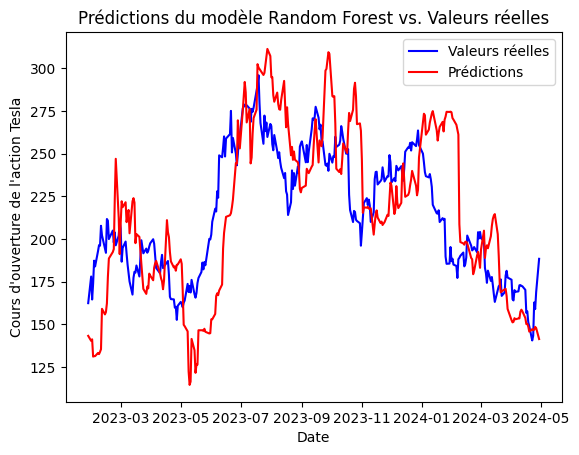

In [20]:
# Tracer les valeurs réelles
plot(dateData2, y_test.values, label='Valeurs réelles', color='blue')

# Tracer les prédictions
plot(dateData2, y_pred, label='Prédictions', color='red')

title('Prédictions du modèle Random Forest vs. Valeurs réelles')
xlabel('Date')
ylabel('Cours d\'ouverture de l\'action Tesla')
legend()

show()


On obtient le même 

Nous allons essayer sur une période encore plus petite comme un jour


In [4]:
data2 = pandas.read_csv('TSLA.csv', delimiter=',', decimal='.', parse_dates=['Date'])
data2.dropna()
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1572 non-null   datetime64[ns]
 1   Open       1572 non-null   float64       
 2   High       1572 non-null   float64       
 3   Low        1572 non-null   float64       
 4   Close      1572 non-null   float64       
 5   Adj Close  1572 non-null   float64       
 6   Volume     1572 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 86.1 KB


   PreviousClose1  PreviousOpen1  PreviousHigh1  PreviousLow1  \
0             NaN            NaN            NaN           NaN   
1       23.054667      23.009333      23.218000     22.811333   
2       23.620667      23.167334      23.746000     23.012667   
3       23.283333      23.400000      23.977333     23.242001   
4       22.916668      23.229334      23.463333     22.700666   

   PreviousVolume1  PreviousAdj Close1  Year  Month  Day  DayOfWeek  EndOfYear  
0              NaN                 NaN  2018      1   30          1      False  
1       70765500.0           23.054667  2018      1   31          2      False  
2       93211500.0           23.620667  2018      2    1          3      False  
3       62965500.0           23.283333  2018      2    2          4      False  
4       55572000.0           22.916668  2018      2    5          0      False  
0    23.009333
1    23.167334
2    23.400000
3    23.229334
4    22.531334
Name: Open, dtype: float64
RMSE: 7.9783076266737

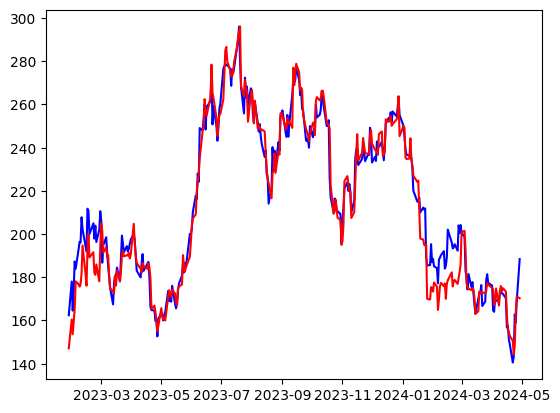

In [5]:
for i in range(1, 2):
    data2[f'PreviousClose{i}'] = data2['Close'].shift(i)
    data2[f'PreviousOpen{i}'] = data2['Open'].shift(i)
    data2[f'PreviousHigh{i}'] = data2['High'].shift(i)
    data2[f'PreviousLow{i}'] = data2['Low'].shift(i)
    data2[f'PreviousVolume{i}'] = data2['Volume'].shift(i)
    data2[f'PreviousAdj Close{i}'] = data2['Adj Close'].shift(i)

data2.drop(['High', 'Low', 'Close', 'Volume', 'Adj Close'],axis=1,inplace=True)

#Add new columns for the year, month, day, day of week, and end of year
data2['Year'] = data2['Date'].dt.year
data2['Month'] = data2['Date'].dt.month
data2['Day'] = data2['Date'].dt.day
data2['DayOfWeek'] = data2['Date'].dt.dayofweek
data2['EndOfYear'] = data2['Date'].dt.is_year_end

dateData2 = data2['Date']

# Diviser les données en fonctionnalités (X) et cible (y)
X = data2.drop(columns=['Date', 'Open'])  # Supprimer la colonne de date et la cible

print(X.head())

y = data2['Open']  # Utiliser le cours d'ouverture comme cible

print(y.head())

index = int(len(data2) * 0.8)

dateData2 = dateData2[index:]



# Diviser les données en ensembles d'entraînement et de test
X_train = X[:index]
X_test = X[index:]
y_train = y[:index]
y_test = y[index:]

# Entraîner un modèle Random Forest avec bootstrapping
model = RandomForestRegressor(n_estimators=100, random_state=42, bootstrap=True)
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
predictions = model.predict(X_test)

# Calculer l'erreur quadratique moyenne (RMSE)
rmse = numpy.sqrt(mean_squared_error(y_test, predictions))
n_rmse= rmse / y_test.mean()
print(f'RMSE: {rmse}')
print(f'Normalized RMSE: {n_rmse}')

print('Predictions shape :' + str(predictions.shape))
print('y_test shape :' + str(y_test.shape))
print('X_test shape :' + str(X_test.shape))
print('dateData2 shape :' + str(dateData2.shape))

plot(dateData2, y_test, 'b-')
plot(dateData2, predictions, 'r-')
show()


Le résultat obtenu est bien plus satisfaisant. Cependant ce n'est pas forcément quelque chose d'exploitable, en effet la durée choisie étant d'un jour, il est relativement facile de trouver le cours d'après car, en général, le cours d'hier sera très proche du cours aujourd'hui et il n'y a pas de très grosses variations du jour au lendemain sauf dans de temps en temps, et d'ailleurs on observe sur le graphe que lorsque l'action change d'un coup (tweet d'Elon Musk par exemple...) la prédiction du modèle commence à bien s'écarter avant de revenir proche des valeurs tests. Ainsi pour ce genre de méthode avec une très courte durée (1 jour), je pense qu'utiliser un algorithme de Machine Learning c'est un peu écraser une mouche avec un marteau-pilon. 


Par exemple pour le SP500, îndice américain des 500 plus grandres entreprise américaines, au varation relativement faible et relativement croissant au cours des années, une méthode assez simple pour le modéliser est de dire que le cours d'hier est égal au cours de demain. 

Ainsi si nous voulons vraiment obtenir un modèle puissant, nous devons nous intéresser au modèle LSTM.

### Partie 2 : LSTM

Pour aller plus loin et obtenir quelque chose de plus efficace, nous allons utiliser la méthode LSTM (on va voir du tensorflow!)

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

2024-05-12 17:27:10.070976: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-12 17:27:11.493588: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-12 17:27:14.644453: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 17:27:20.036722: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [40]:
# Charger les données depuis le fichier CSV
dataOriginal = pandas.read_csv('TSLA2.csv')
data3 = dataOriginal.copy()

# Créer des séquences de données
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data.iloc[i + seq_length]['Open'])  # Utiliser la valeur d'ouverture comme cible
    return numpy.array(X), numpy.array(y)

# Convertir les colonnes de type Timestamp en valeurs numériques
data['Date'] = pandas.to_numeric(data['Date'])


seq_length = 10  # Longueur de la séquence
X, y = create_sequences(data, seq_length)

# Diviser les données en ensembles d'entraînement et de test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Créer le modèle LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, len(data.columns))))  # Utiliser le nombre de colonnes comme input_shape
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entraîner le modèle
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Faire des prédictions sur l'ensemble de test
predictions = model.predict(X_test)

# Calculer l'erreur quadratique moyenne (RMSE)
rmse = numpy.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')
print(f'Normalized RMSE: {rmse / y_test.mean()}')

# Tracer les valeurs réelles et les comparer aux prédictions
plot(y_test, label='Valeurs réelles', color='blue')
plot(predictions, label='Prédictions', color='red')
title('Prédictions du modèle LSTM vs. Valeurs réelles')
xlabel('Date')
ylabel('Cours d\'ouverture de l\'action Tesla')
legend()
show()



/home/bast/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

/home/bast/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.1257
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0031
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0013
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0012
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0012
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0010
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 8.9510e-04
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0010
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0010
Epoch 10/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 8.0152e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
RMSE: 10.590407585628933
Normalized RMSE: 0.048706530453361006


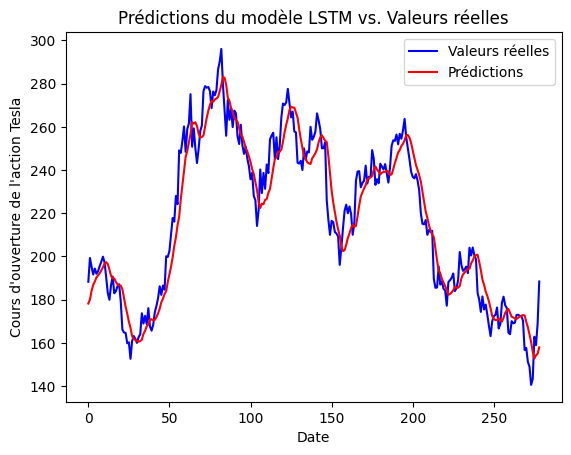

In [24]:
# Charger les données depuis le fichier CSV
dataOriginal = pandas.read_csv('TSLA2.csv')['Open'].values.reshape(-1, 1)
data3 = dataOriginal.copy()

# Normaliser les données
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data3)

# Créer des séquences de données
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return numpy.array(X), numpy.array(y)

seq_length = 180  # Longueur de la séquence
X, y = create_sequences(data_normalized, seq_length)

# Diviser les données en ensembles d'entraînement et de test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Créer le modèle LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entraîner le modèle
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Faire des prédictions sur l'ensemble de test
predictions = model.predict(X_test)

# Inverser la normalisation des prédictions et des valeurs réelles
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

# Calculer l'erreur quadratique moyenne (RMSE)
rmse = numpy.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')
print(f'Normalized RMSE: {rmse / y_test.mean()}')

# Tracer les valeurs réelles et les comparer aux prédictions
plot(y_test, label='Valeurs réelles', color='blue')
plot(predictions, label='Prédictions', color='red')
title('Prédictions du modèle LSTM vs. Valeurs réelles')
xlabel('Date')
ylabel('Cours d\'ouverture de l\'action Tesla')
legend()
show()



In [5]:
dataOriginal = pandas.read_csv('TSLA2.csv', delimiter=',', decimal='.', parse_dates=['Date'])
data3 = dataOriginal.copy()
data3.dropna()
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1572 non-null   datetime64[ns]
 1   Open       1572 non-null   float64       
 2   High       1572 non-null   float64       
 3   Low        1572 non-null   float64       
 4   Close      1572 non-null   float64       
 5   Adj Close  1572 non-null   float64       
 6   Volume     1572 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 86.1 KB


In [6]:
data3.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-30,23.009333,23.218000,22.811333,23.054667,23.054667,70765500
1,2018-01-31,23.167334,23.746000,23.012667,23.620667,23.620667,93211500
2,2018-02-01,23.400000,23.977333,23.242001,23.283333,23.283333,62965500
3,2018-02-02,23.229334,23.463333,22.700666,22.916668,22.916668,55572000
4,2018-02-05,22.531334,22.964666,22.200001,22.208668,22.208668,66961500


In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

dataOriginal = pandas.read_csv('TSLA2.csv', delimiter=',', decimal='.', parse_dates=['Date'])

print(dataOriginal.head())

data3 = dataOriginal.copy()

print(data3.head())

seq_length=180

# Shift the data to create a sequence of seq_length previous values
for i in range(seq_length, seq_length*2):
    data3[f'PreviousOpen{i}'] = data3['Open'].shift(i)

data3.drop(['High', 'Low', 'Close', 'Volume', 'Adj Close'],axis=1,inplace=True)
data3.dropna(inplace=True)

# Put the date with a good format
data3['Year'] = data3['Date'].dt.year
data3['Month'] = data3['Date'].dt.month
data3['Day'] = data3['Date'].dt.day
data3['DayOfWeek'] = data3['Date'].dt.dayofweek
data3['EndOfYear'] = data3['Date'].dt.is_year_end

dateData3 = data3['Date']
print("data3")
print(data3.head())

# On divise les données en X et y
X = data3.drop(columns=['Date', 'Open'])  # On supprime la colonne de date et la cible
print(X.head())

y = data3['Open']  # On utilise le cours d'ouverture comme notre y
print(y.head())
# Diviser les données en ensembles d'entraînement et de test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Créer le modèle LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entraîner le modèle
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Faire des prédictions sur l'ensemble de test
predictions = model.predict(X_test)

# Calculer l'erreur quadratique moyenne (RMSE)
rmse = numpy.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')
print(f'Normalized RMSE: {rmse / y_test.mean()}')




        Date       Open       High        Low      Close  Adj Close    Volume
0 2018-01-30  23.009333  23.218000  22.811333  23.054667  23.054667  70765500
1 2018-01-31  23.167334  23.746000  23.012667  23.620667  23.620667  93211500
2 2018-02-01  23.400000  23.977333  23.242001  23.283333  23.283333  62965500
3 2018-02-02  23.229334  23.463333  22.700666  22.916668  22.916668  55572000
4 2018-02-05  22.531334  22.964666  22.200001  22.208668  22.208668  66961500
        Date       Open       High        Low      Close  Adj Close    Volume
0 2018-01-30  23.009333  23.218000  22.811333  23.054667  23.054667  70765500
1 2018-01-31  23.167334  23.746000  23.012667  23.620667  23.620667  93211500
2 2018-02-01  23.400000  23.977333  23.242001  23.283333  23.283333  62965500
3 2018-02-02  23.229334  23.463333  22.700666  22.916668  22.916668  55572000
4 2018-02-05  22.531334  22.964666  22.200001  22.208668  22.208668  66961500


/tmp/ipykernel_4549/3795755687.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data3[f'PreviousOpen{i}'] = data3['Open'].shift(i)
/tmp/ipykernel_4549/3795755687.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data3[f'PreviousOpen{i}'] = data3['Open'].shift(i)
/tmp/ipykernel_4549/3795755687.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a 

data3
          Date       Open  PreviousOpen180  PreviousOpen181  PreviousOpen182  \
359 2019-07-05  15.638000        17.270666        17.400000        17.168667   
360 2019-07-08  15.416000        17.713333        17.270666        17.400000   
361 2019-07-09  15.264667        18.826668        17.713333        17.270666   
362 2019-07-10  15.610000        17.952667        18.826668        17.713333   
363 2019-07-11  15.876000        17.826000        17.952667        18.826668   

     PreviousOpen183  PreviousOpen184  PreviousOpen185  PreviousOpen186  \
359        17.640667        17.016666        17.634666        18.309999   
360        17.168667        17.640667        17.016666        17.634666   
361        17.400000        17.168667        17.640667        17.016666   
362        17.270666        17.400000        17.168667        17.640667   
363        17.713333        17.270666        17.400000        17.168667   

     PreviousOpen187  ...  PreviousOpen355  PreviousOpen356  P

KeyboardInterrupt: 

In [26]:
print('Predictions shape :' + str(predictions.shape))
print('y_test shape :' + str(y_test.shape))
print('X_test shape :' + str(X_test.shape))
print('dateData3 shape :' + str(dateData3.shape))

dateData3 = dateData3[split:]
print('dateData3 shape :' + str(dateData3.shape))


Predictions shape :(311, 1)
y_test shape :(311,)
X_test shape :(311, 15)
dateData3 shape :(1553,)
dateData3 shape :(311,)


In [1]:
# Tracer les valeurs réelles et les comparer aux prédictions
plot(dateData3, y_test, label='Valeurs réelles', color='blue')
plot(dateData3, predictions, label='Prédictions', color='red')
title('Prédictions du modèle LSTM vs. Valeurs réelles')
xlabel('Date')
ylabel('Cours d\'ouverture de l\'action Tesla')
legend()
show()


NameError: name 'plot' is not defined